## Clasificando rostros humanos usando redes neuronales convolucionales (ConvNet's)

El objetivo de este taller es introducir la arquitectura de red neuronal convolucional clásica (ConvNet) LeNet-5 a los asistentes usando python, tensor-flow y sci-kit learn. Los asistentes aprenderán los conceptos básicos y cómo construir una ConvNet clasificando si sí o no una imagen tiene un rostro humano.

Puntos del taller:

* Breve introducción a los Fundamentos de la Red Neuronal Convolucional usando la Arquitectura LeNet-5
* Preparación de datos usando numpy y sklearn
* Construyendo una ConvNet con Tensor-flow
* Uso de ConvNet para detectar sí o no una imagen tiene una cara humana
* Conclusiones

In [1]:
# Library and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import glob
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Markdown, display
import time
import random

%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
image = cv2.imread('./data/faces/no_faces/n02086240_936.jpg', 0)

#### Implementación de convolución en tensorflow

In [4]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
W = tf.get_variable('weights', [5, 5, 1, 16], initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32), dtype=tf.float32)
conv1 = tf.nn.conv2d(x, W, [1, 1, 1, 1], 'SAME')
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(conv1)
    

In [5]:
result.shape

(1, 80, 80, 16)

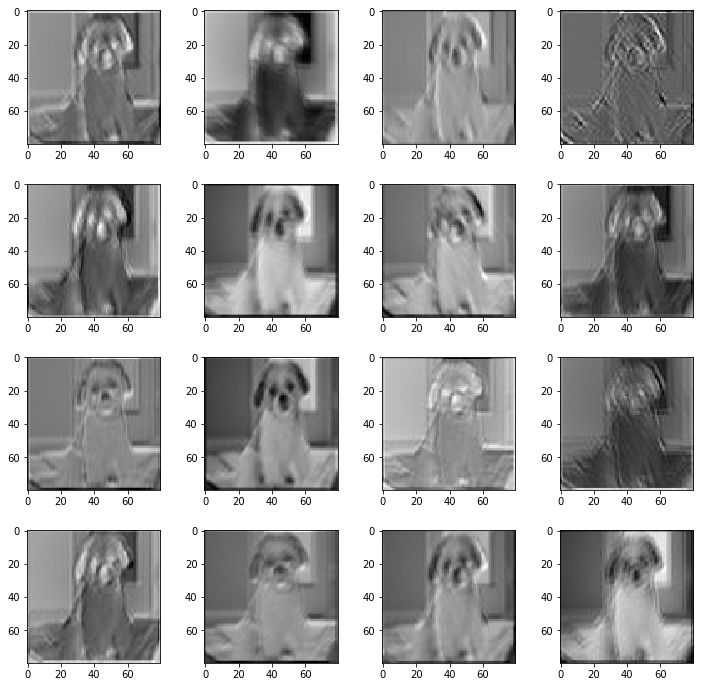

In [6]:
fig, draws = plt.subplots(4,4, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(result.shape[-1]):    
    draws[idx].imshow(result[0, :, :, idx], cmap="gray")

#### Implementación de maxpooling en tensorflow

In [7]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
pool1 = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(pool1)

print("image after pooling", result.shape)

image after pooling (1, 39, 39, 1)


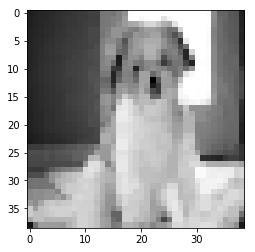

In [8]:
plt.imshow(result[0, :, :, 0], cmap="gray")

### LeNet-5 Architecture

<img src="https://moisesvw.github.io/img/lenet-5.png">
fuente: [Yan LeCun](http://yann.lecun.com/exdb/lenet/)

La estructura de esta red es la siguiente:
- Imagen de entrada de 32x32 pixeles
- Convolución 1 kernel(5, 5), 6 filtros
- Submuestreo con Maxpooling kernel(2,2), slides(2,2)
- Convolución 2 kernel(5, 5), 16 filtros
- Submuestreo con Maxpooling kernel(2,2), slides(2,2)
- red estandar 120
- red estandar 84
- salida 10 (softmax)

Este ejercicio usa un subconjunto de los datos originales que se pueden encontrar en estos enlaces

- http://vis-www.cs.umass.edu/lfw
- https://www.kaggle.com/slothkong/10-monkey-species/data
- http://vision.stanford.edu/aditya86/ImageNetDogs/



#### Preparación de datos

In [9]:
images_path = glob.glob("./data/faces/**/*.jpg")
labels = { 'faces': 1, 'no_faces': 0 }
data = pd.DataFrame([ {'path': x, 'label': labels[x.split("/")[-2]]} for x in images_path]).sample(4000)

In [10]:
data.head()

,label,path
2553,1,./data/faces/faces/George_W_Bush_0051.jpg
1833,0,./data/faces/no_faces/n02088238_12966.jpg
2451,1,./data/faces/faces/Fernando_Gonzalez_0002.jpg
57,0,./data/faces/no_faces/n02113978_3480.jpg
3324,1,./data/faces/faces/Sedigh_Barmak_0001.jpg


In [11]:
data.groupby('label').count()

,path
label,
0,2000
1,2000


In [12]:
x_train, x_test, y_train, y_test = train_test_split(data['path'], data['label'], test_size=0.1)

#### Modelo

In [15]:
#helper functions
def get_images(images_path, newaxis=False):
    images = []
    for path in images_path:
        if newaxis:
            im = cv2.imread(path, 0)[:, :, np.newaxis].astype(np.float32)
        else:
            im = cv2.imread(path, 0)
        images.append(im)

    return np.array(images)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy_ = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy_ * len(batch_x))
    return total_accuracy / num_examples

signs_labels = [chr(i) for i in range(ord('A'), ord('Z')+1)]

In [16]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 80,80, 1), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 2)

# parameters layer 1
W1 = tf.get_variable("W1", (5, 5, 1, 6), initializer = tf.truncated_normal_initializer())
b1 = tf.get_variable("b1", initializer = np.zeros(6, dtype=np.float32))
Z1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
A1 = tf.nn.relu(Z1)
A1max_pool = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# parameters layer 2
W2 = tf.get_variable("W2", (5, 5, 6, 16), initializer = tf.truncated_normal_initializer())
b2 = tf.get_variable("b2", initializer = np.zeros(16, dtype=np.float32))
Z2 = tf.nn.conv2d(A1max_pool, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
A2 = tf.nn.relu(Z2)
A2max_pool = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
A2flat = flatten(A2max_pool)

# parameters layer 3
W3 = tf.get_variable("W3", (4624, 120), initializer = tf.truncated_normal_initializer())
b3 = tf.get_variable("b3", initializer = np.zeros(120, dtype=np.float32))
Z3 = tf.add(tf.tensordot(A2flat, W3, [[1], [0]]), b3)
A3 = tf.nn.relu(Z3)

# parameters layer 4
W4 = tf.get_variable("W4", (120, 84), initializer = tf.truncated_normal_initializer())
b4  = tf.get_variable("b4", initializer = np.zeros(84, dtype=np.float32))
Z4 = tf.add(tf.tensordot(A3, W4, [[1], [0]]), b4)
A4 = tf.nn.relu(Z4)

# parameters output layer
W_l = tf.get_variable("W_l", (84, 2), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(2, dtype=np.float32))

logits = tf.add(tf.tensordot(A4, W_l, [[1], [0]]), b_l)

# trainning
entropy   = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()

In [17]:
BATCH_SIZE = 64
EPOCHS = 5
EVALUATE_EVERY_N_EPOCHS = 5 # epochs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end], newaxis=True), y_train[offset:end]

            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train, newaxis=True), y_train)
            validation_accuracy = evaluate(get_images(x_test, newaxis=True), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './lenet-5')

EPOCH(0)	 -> Train Accuracy = 0.722 | Validation Accuracy = 0.695
trainning elapsed time 432.73 seconds


### prediccion

In [23]:
test_images = [ cv2.resize(x, (80,80)) for x in get_images(glob.glob("./images/faces/*.jpg")) ]


In [24]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './lenet-5')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: [x_[:,:, np.newaxis] for x_ in test_images] })
    pred_labels = np.argmax(logs, axis=1)


INFO:tensorflow:Restoring parameters from ./lenet-5


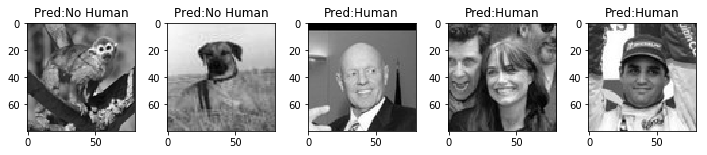

In [25]:
labels = { 1: "Human", 0: "No Human" }
fig, draws = plt.subplots(1,5, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(len(pred_labels)):
    draws[idx].set_title("Pred:" + labels[pred_labels[idx]])
    im =  test_images[idx]
    draws[idx].imshow(im, cmap="gray")